In [1]:
import tensorboard as tb
import tensorflow as tf
print(tf.__version__)

2024-08-08 16:45:34.514324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
summary_dir = "../system/controller/reachability_estimator/runs/"

In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

COMPUTER = 'lxhalle.stud.rbg.tum.de'
DATASET_FEATURES = ''

from collections import defaultdict
Features = str
Date = str
Metric = str
data: dict[Date, dict[Features, dict[Metric, float]]] = defaultdict(lambda: defaultdict(dict))

for event_file in os.listdir(summary_dir):
    date, time, descr = event_file.split('_', maxsplit=2)
    if not descr.startswith(COMPUTER):
        continue
    descr = descr.removeprefix(COMPUTER)
    descr = descr.split('+')
    #features, *descr = descr
    #if features != DATASET_FEATURES:
    #    continue
    event_file = os.path.join(summary_dir, event_file)
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    #print(date, time, descr)
    date = date + '/T' + time[:2]
    descr = data[date][tuple(descr)]
    for tagtype, tags in event_acc.Tags().items():
        if 'graph' in tagtype:
            continue
        for tag in tags:
            events = getattr(event_acc, tagtype.title())(tag)
            descr[tag] = events[-1].value
            #print(tagtype, tag, ':', events[-1].value, 'events')

In [5]:
def only_default_features(features):
    if 'crop' in ''.join(features):
        return False
    return True

def filter_runs(data, date_filter= lambda data:True, feature_filter=only_default_features):
    labels: list[Date] = []
    x: list[list[Features]] = []
    y: list[list[Metric]] = []

    for date in data.keys():
        if not date_filter(date):
            continue
        data[date] = dict(data[date])
        scores = []
        features = []
        for feature in data[date]:
            if not feature_filter(feature):
                continue
            data[date][feature] = dict(data[date][feature])
            try:
                score = data[date][feature]['Metrics/Fscore']
            except KeyError:
                continue
            #if 'fc256,128,64,32,16' not in feature:
            #    feature = list(feature)
            #    feature.remove('fc256,128,64,32,16')
            #    feature = tuple(feature)
            scores.append(score)
            features.append('+'.join(feature))
        labels.append(date)
        x.append(features)
        y.append(scores)
    return x, y, labels

import matplotlib.pyplot as plt

def plot_runs(x, y, labels=None):
    fig, ax = plt.subplots()
    if labels:
        for xi, yi, labeli in sorted(zip(x, y, labels), key=lambda tup: tup[2]):
            ax.scatter(xi, yi, label=labeli)
            fig.legend()
    else:
        xi, yi = sum(x, start=[]), sum(y, start=[])
        ax.scatter(xi, yi)
    fig.autofmt_xdate()
    return fig

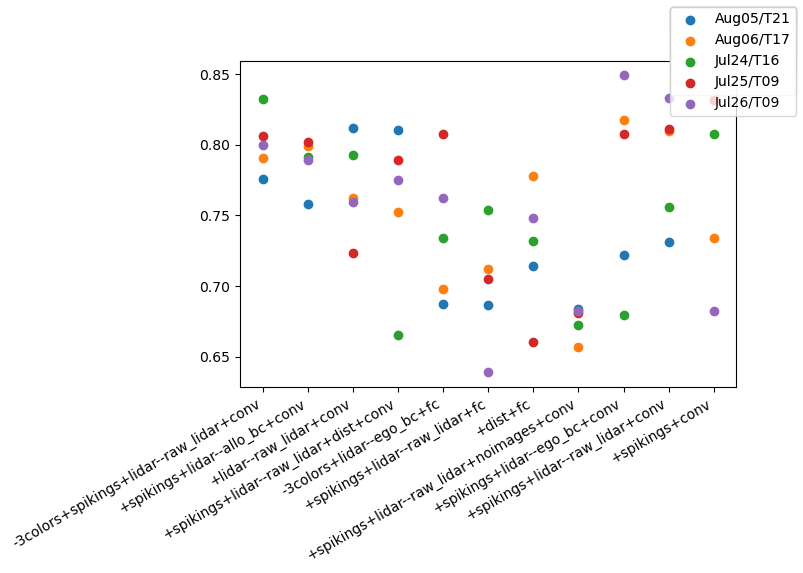

In [14]:
suitable_date = lambda date: (date[:3] == 'Jul' and int(date[3:5]) >= 24) or date[:3] == 'Aug'
#suitable_date = lambda date: date != 'Jul05/T13'

#x, y, labels = filter_runs(data, date_filter=suitable_date, feature_filter=lambda features:'crop' in ''.join(features))
#fig = plot_runs(x, y)
#fig.savefig('../../report/figures/train_results_crop.pgf')

x, y, labels = filter_runs(data, suitable_date)
_fig = plot_runs(x, y, labels)

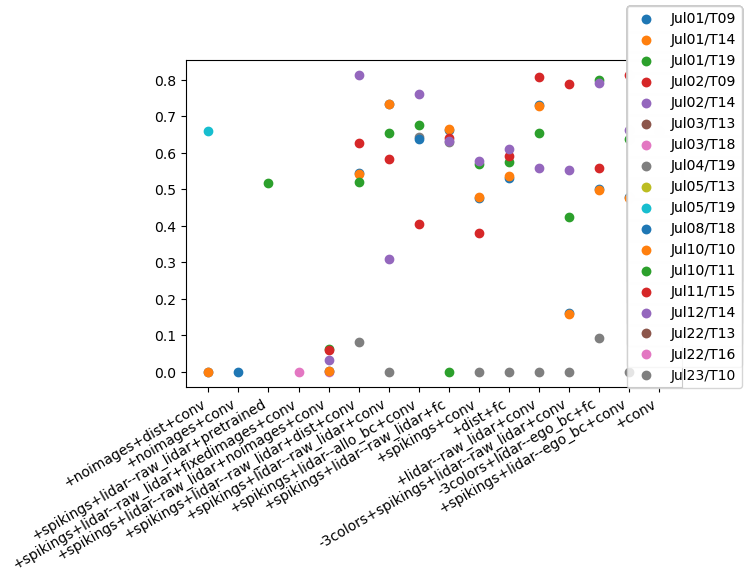

In [20]:
x, y, labels = filter_runs(
    data,
    lambda date: (date[:3] == 'Jul' and int(date[3:5]) < 24),
    lambda features: ('dropout' not in ''.join(features) and 'fc256' not in ''.join(features) and 'crop' not in ''.join(features))
)
_fig = plot_runs(x, y, labels)

In [29]:
from collections import defaultdict
values_by_date: dict[Features, list[Metric]] = defaultdict(list)
for xi, yi in zip(x, y):
    for xij, yij in zip(xi, yi):
        values_by_date[xij].append(yij)
assert labels == ['Jul24/T16', 'Jul25/T09']
obsolete = []
for features, values in values_by_date.items():
    assert len(values) == 2, values
    if values[0] < values[1]:
        obsolete.append(features)
print(' '.join(obsolete))

AssertionError: 

In [30]:
values = defaultdict(list)
for xi, yi, labeli in zip(x, y, labels):
    for tag, value in zip(xi, yi):
        values[tag].append(value)

In [39]:
default_config = {'spikings', 'conv'}
def pretty_tag(tag):
    pretty = []
    tag = set(tag.split('+'))
    if '-3colors' in tag:
        pretty.append('3 wall colors')
        tag.remove('-3colors')
    else:
        tag.remove('')
    lidar = next(filter(lambda s: s.startswith('lidar--'), tag), None)
    if lidar is None:
        pretty.append('no lidar')
    else:
        tag.remove(lidar)
        lidar = lidar.removeprefix('lidar--')
        if lidar != 'raw_lidar':
            lidar = lidar.removesuffix('_bc')
            pretty.append(lidar + 'centric BVC spikings instead of lidar')
    if 'conv' in tag:
        tag.remove('conv')
    else:
        pretty.append('fully connected image encoder')
        tag.remove('fc')
    if 'spikings' in tag:
        tag.remove('spikings')
    else:
        pretty.append('GC spikings not provided')
    if 'dist' in tag:
        pretty.append('distance provided')
        tag.remove('dist')
    if 'noimages' in tag:
        pretty.append('images not provided')
        tag.remove('noimages')
    assert len(tag) == 0, tag
    if len(pretty) == 0:
        pretty = ['Default']
    return pretty

import pandas as pd
#tags = [', '.join(pretty_tag(tag)) for tag in values.keys()]
tags = values.keys()
#assert all(map(lambda i: i==5, map(len, values.values())))
df = pd.DataFrame({ 'tags': tags, 'max': map(max, values.values())})
df.sort_values(by='max', ascending=False)

,tags,max
0,+cropX20+conv,0.786467
3,+cropX10+conv,0.748703
2,+cropN20+conv,0.647837
1,+cropN10+conv,0.616498


In [38]:
help(df.sort_values)

Help on method sort_values in module pandas.core.frame:

sort_values(by: 'IndexLabel', *, axis: 'Axis' = 0, ascending: 'bool | list[bool] | tuple[bool, ...]' = True, inplace: 'bool' = False, kind: 'SortKind' = 'quicksort', na_position: 'str' = 'last', ignore_index: 'bool' = False, key: 'ValueKeyFunc | None' = None) -> 'DataFrame | None' method of pandas.core.frame.DataFrame instance
    Sort by the values along either axis.

    Parameters
    ----------
    by : str or list of str
        Name or list of names to sort by.

        - if `axis` is 0 or `'index'` then `by` may contain index
          levels and/or column labels.
        - if `axis` is 1 or `'columns'` then `by` may contain column
          levels and/or index labels.
    axis : "{0 or 'index', 1 or 'columns'}", default 0
         Axis to be sorted.
    ascending : bool or list of bool, default True
         Sort ascending vs. descending. Specify list for multiple sort
         orders.  If this is a list of bools, must ma

In [40]:
print(df.sort_values(by='max', ascending=False).to_latex(index=False))

\begin{tabular}{lr}
\toprule
tags & max \\
\midrule
+cropX20+conv & 0.786467 \\
+cropX10+conv & 0.748703 \\
+cropN20+conv & 0.647837 \\
+cropN10+conv & 0.616498 \\
\bottomrule
\end{tabular}



In [9]:
baseline = df[df['tags'] == 'spikings+lidar--raw_lidar+conv']['max']
baseline = next(iter(baseline))
df['max'] = df['max'] - baseline
df

StopIteration: 

In [6]:
relevant_series = filter(lambda tup: tup[2] in ['Jul10/T10', 'Jul08/T18', 'Jul05/T19'], zip(x, y, labels))
relevant_series = list(relevant_series)
relevant_series

[(['spikings+lidar--raw_lidar+fc',
   'spikings+lidar--raw_lidar+noimages+conv',
   'dist+fc',
   'spikings+lidar--raw_lidar+dist+conv',
   'spikings+lidar--raw_lidar+conv',
   'lidar--raw_lidar+conv',
   'spikings+conv',
   'spikings+lidar--ego_bc+conv'],
  [0.6643402576446533,
   0.0007231528288684785,
   0.5362153053283691,
   0.5430660843849182,
   0.7349265217781067,
   0.7282484769821167,
   0.47915971279144287,
   0.4768792390823364],
  'Jul10/T10'),
 (['spikings+lidar--allo_bc+conv',
   'lidar--raw_lidar+conv',
   'spikings+lidar--raw_lidar+dist+conv',
   'spikings+lidar--raw_lidar+conv',
   'spikings+lidar--raw_lidar+fc',
   'spikings+lidar--ego_bc+conv',
   'spikings+conv',
   'dist+fc',
   'spikings+lidar--raw_lidar+noimages+conv'],
  [0.6391246914863586,
   0.7310674786567688,
   0.5446760058403015,
   0.7338154911994934,
   0.6639044880867004,
   0.47912880778312683,
   0.47506582736968994,
   0.5307824015617371,
   0.0006844444433227181],
  'Jul08/T18')]

In [7]:
from collections import defaultdict

results = defaultdict(dict)
for tags, values, date in relevant_series:
    for tag, value in zip(tags, values):
        results[tag][date] = value
print(f'     \tJul10/T10\tJul08/T18')
for tag, values in results.items():
    print(f'{tag}:\t{values.get('Jul10/T10', '??')}\t{values.get('Jul08/T18', '??')}')

     	Jul10/T10	Jul08/T18
spikings+lidar--raw_lidar+fc:	0.6643402576446533	0.6639044880867004
spikings+lidar--raw_lidar+noimages+conv:	0.0007231528288684785	0.0006844444433227181
dist+fc:	0.5362153053283691	0.5307824015617371
spikings+lidar--raw_lidar+dist+conv:	0.5430660843849182	0.5446760058403015
spikings+lidar--raw_lidar+conv:	0.7349265217781067	0.7338154911994934
lidar--raw_lidar+conv:	0.7282484769821167	0.7310674786567688
spikings+conv:	0.47915971279144287	0.47506582736968994
spikings+lidar--ego_bc+conv:	0.4768792390823364	0.47912880778312683
spikings+lidar--allo_bc+conv:	??	0.6391246914863586
